In [1]:
import picasa 
import anndata as ad
import scanpy as sc
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np


df = pd.read_csv('data/figure2_attention_scores.csv.gz',index_col=0)

##############################################

dfl = pd.DataFrame(df.index.values)
dfl['patient'] = [x.split('@')[0] for x in dfl[0]]
dfl['celltype'] = [x.split('@')[1].split('_')[0] for x in dfl[0]]
dfl['gene'] = [x.split('_')[1] for x in dfl[0]]
dfl.drop(0,axis=1,inplace=True)
dfl.reset_index(inplace=True)


/home/BCCRC.CA/ssubedi/miniconda3/envs/ssubedi/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


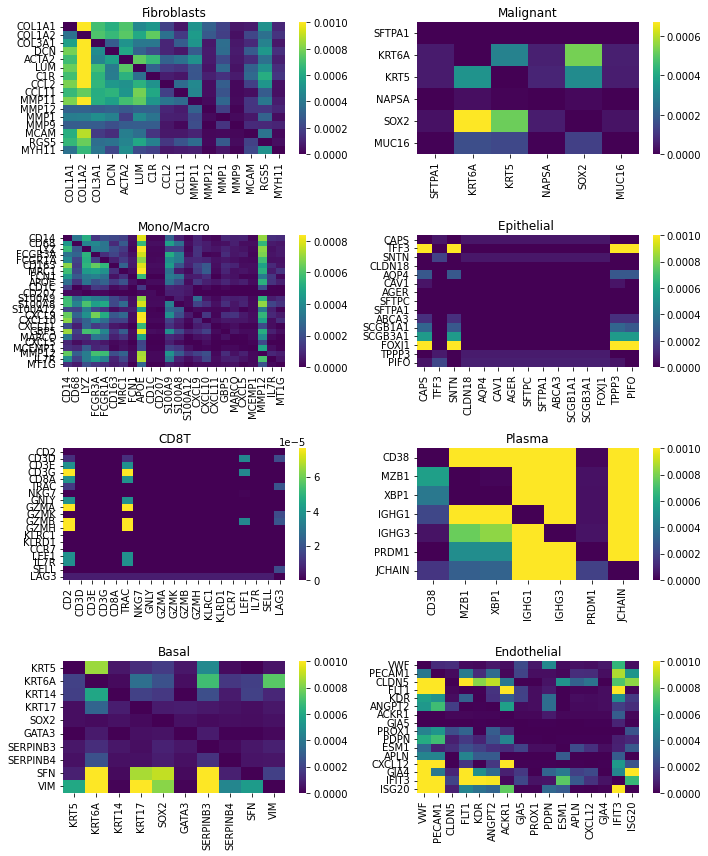

In [3]:
marker = {
    'Malignant': ['EPCAM', 'SFTPA1', 'KRT6A', 'KRT5', 'NAPSA', 'EGFR', 'SOX2', 'MYC', 'TP63', 'DSG3', 'MUC16', 'PAX8', 'CLDN3'],
    
    'Mono/Macro': ['CD14', 'CD68', 'LYZ', 'FCGR3A', 'FCGR1A', 'CD163', 'MRC1', 'FCN1','APOE','CD1C','CD207','S100A9','S100A8','S100A12','CXCL9','CXCL10','CXCL11','GBP5','MARCO','CXCL5','MCEMP1','MMP12','IL7R','MT1G'],
    
    'Fibroblasts': ['COL1A1', 'COL1A2', 'COL3A1', 'DCN', 'ACTA2', 'LUM', 'C1R', 'FAP','CCL2','CCL11','BMP4','MMP11','MMP12','MMP1','MMP9','IFIT1','ACGT2','MCAM','RGS5','MYH11'],
    
    'CD8T': ['CD2', 'CD3D', 'CD3E', 'CD3G', 'CD8A', 'TRAC', 'NKG7', 'GNLY', 'GZMA', 'GZMK', 'GZMB', 'GZMH','KLRC1','KLRD1','CCR7','LEF1','IL7R','SELL','LAG3'],
    
    'Endothelial': ['VWF', 'PECAM1', 'CLDN5', 'FLT1', 'KDR', 'CDH5', 'ANGPT2', 'ACKR1', 'GJA5', 'PROX1', 'PDPN', 'ESM1','APLN','CXCL12','NR2F2','MMRN1','GJA4','EFNB2','IFIT1','IFIT3','ISG20'],
    
    'Plasma': ['CD38', 'SDC1', 'MZB1', 'XBP1', 'IGHG1', 'IGHG3', 'PRDM1','JCHAIN'],
    
    'Basal': ['TP63', 'KRT5', 'KRT6A', 'KRT14', 'KRT17', 'SOX2', 'NGFR',  
    'ITGA6', 'COL17A1', 'TRIM29', 'FOXI1', 'GATA3', 'P63',  
    'SERPINB3', 'SERPINB4', 'LAMB3', 'LAMA3', 'SFN', 'KLF5',  
    'CD44', 'VIM', 'NOTCH1', 'JAG1', 'DLL1'],
    
    'Epithelial ': ['EPCAM','CAPS','TFF3','SNTN','CDH1','CLDN18','AQP4','CAV1','AGER','SFTPC','SFTPA1','ABCA3','SCGB1A1','SCGB3A1','FOXJ1','TPPP3','PIFO']
}
    

unique_celltypes = dfl['celltype'].unique()

fig, axes = plt.subplots(4, 2, figsize=(10, 12))

for idx, ct in enumerate(unique_celltypes):
    
    row, col = idx // 2, idx % 2
    
    ct_ylabel = dfl[dfl['celltype'] == ct].index.values
    df_attn = df.iloc[ct_ylabel,:].copy()
    
    if ct == 'Epithelial' or ct == 'CD8T':
        df_attn[df_attn > .0001] = .0001
    else:
        df_attn[df_attn > .001] = .001

    sel_genes = [x for x in marker[ct] if x in df_attn.columns]
    df_attn = df_attn.loc[:,sel_genes]
    
    df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
    df_attn = df_attn[df_attn['gene'].isin(sel_genes)]
    df_attn = df_attn.groupby('gene').mean()
    
    df_attn = df_attn.loc[sel_genes,sel_genes]
    
    df_attn.columns = [x.split('-')[0] for x in df_attn.columns]
    df_attn.index = [x.split('-')[0] for x in df_attn.index]
    sns.heatmap(df_attn, ax=axes[row, col],
                yticklabels=df_attn.index,  
                xticklabels=df_attn.columns,  
                cmap='viridis' 
                )
    axes[row, col].set_title(ct)
    
plt.tight_layout()

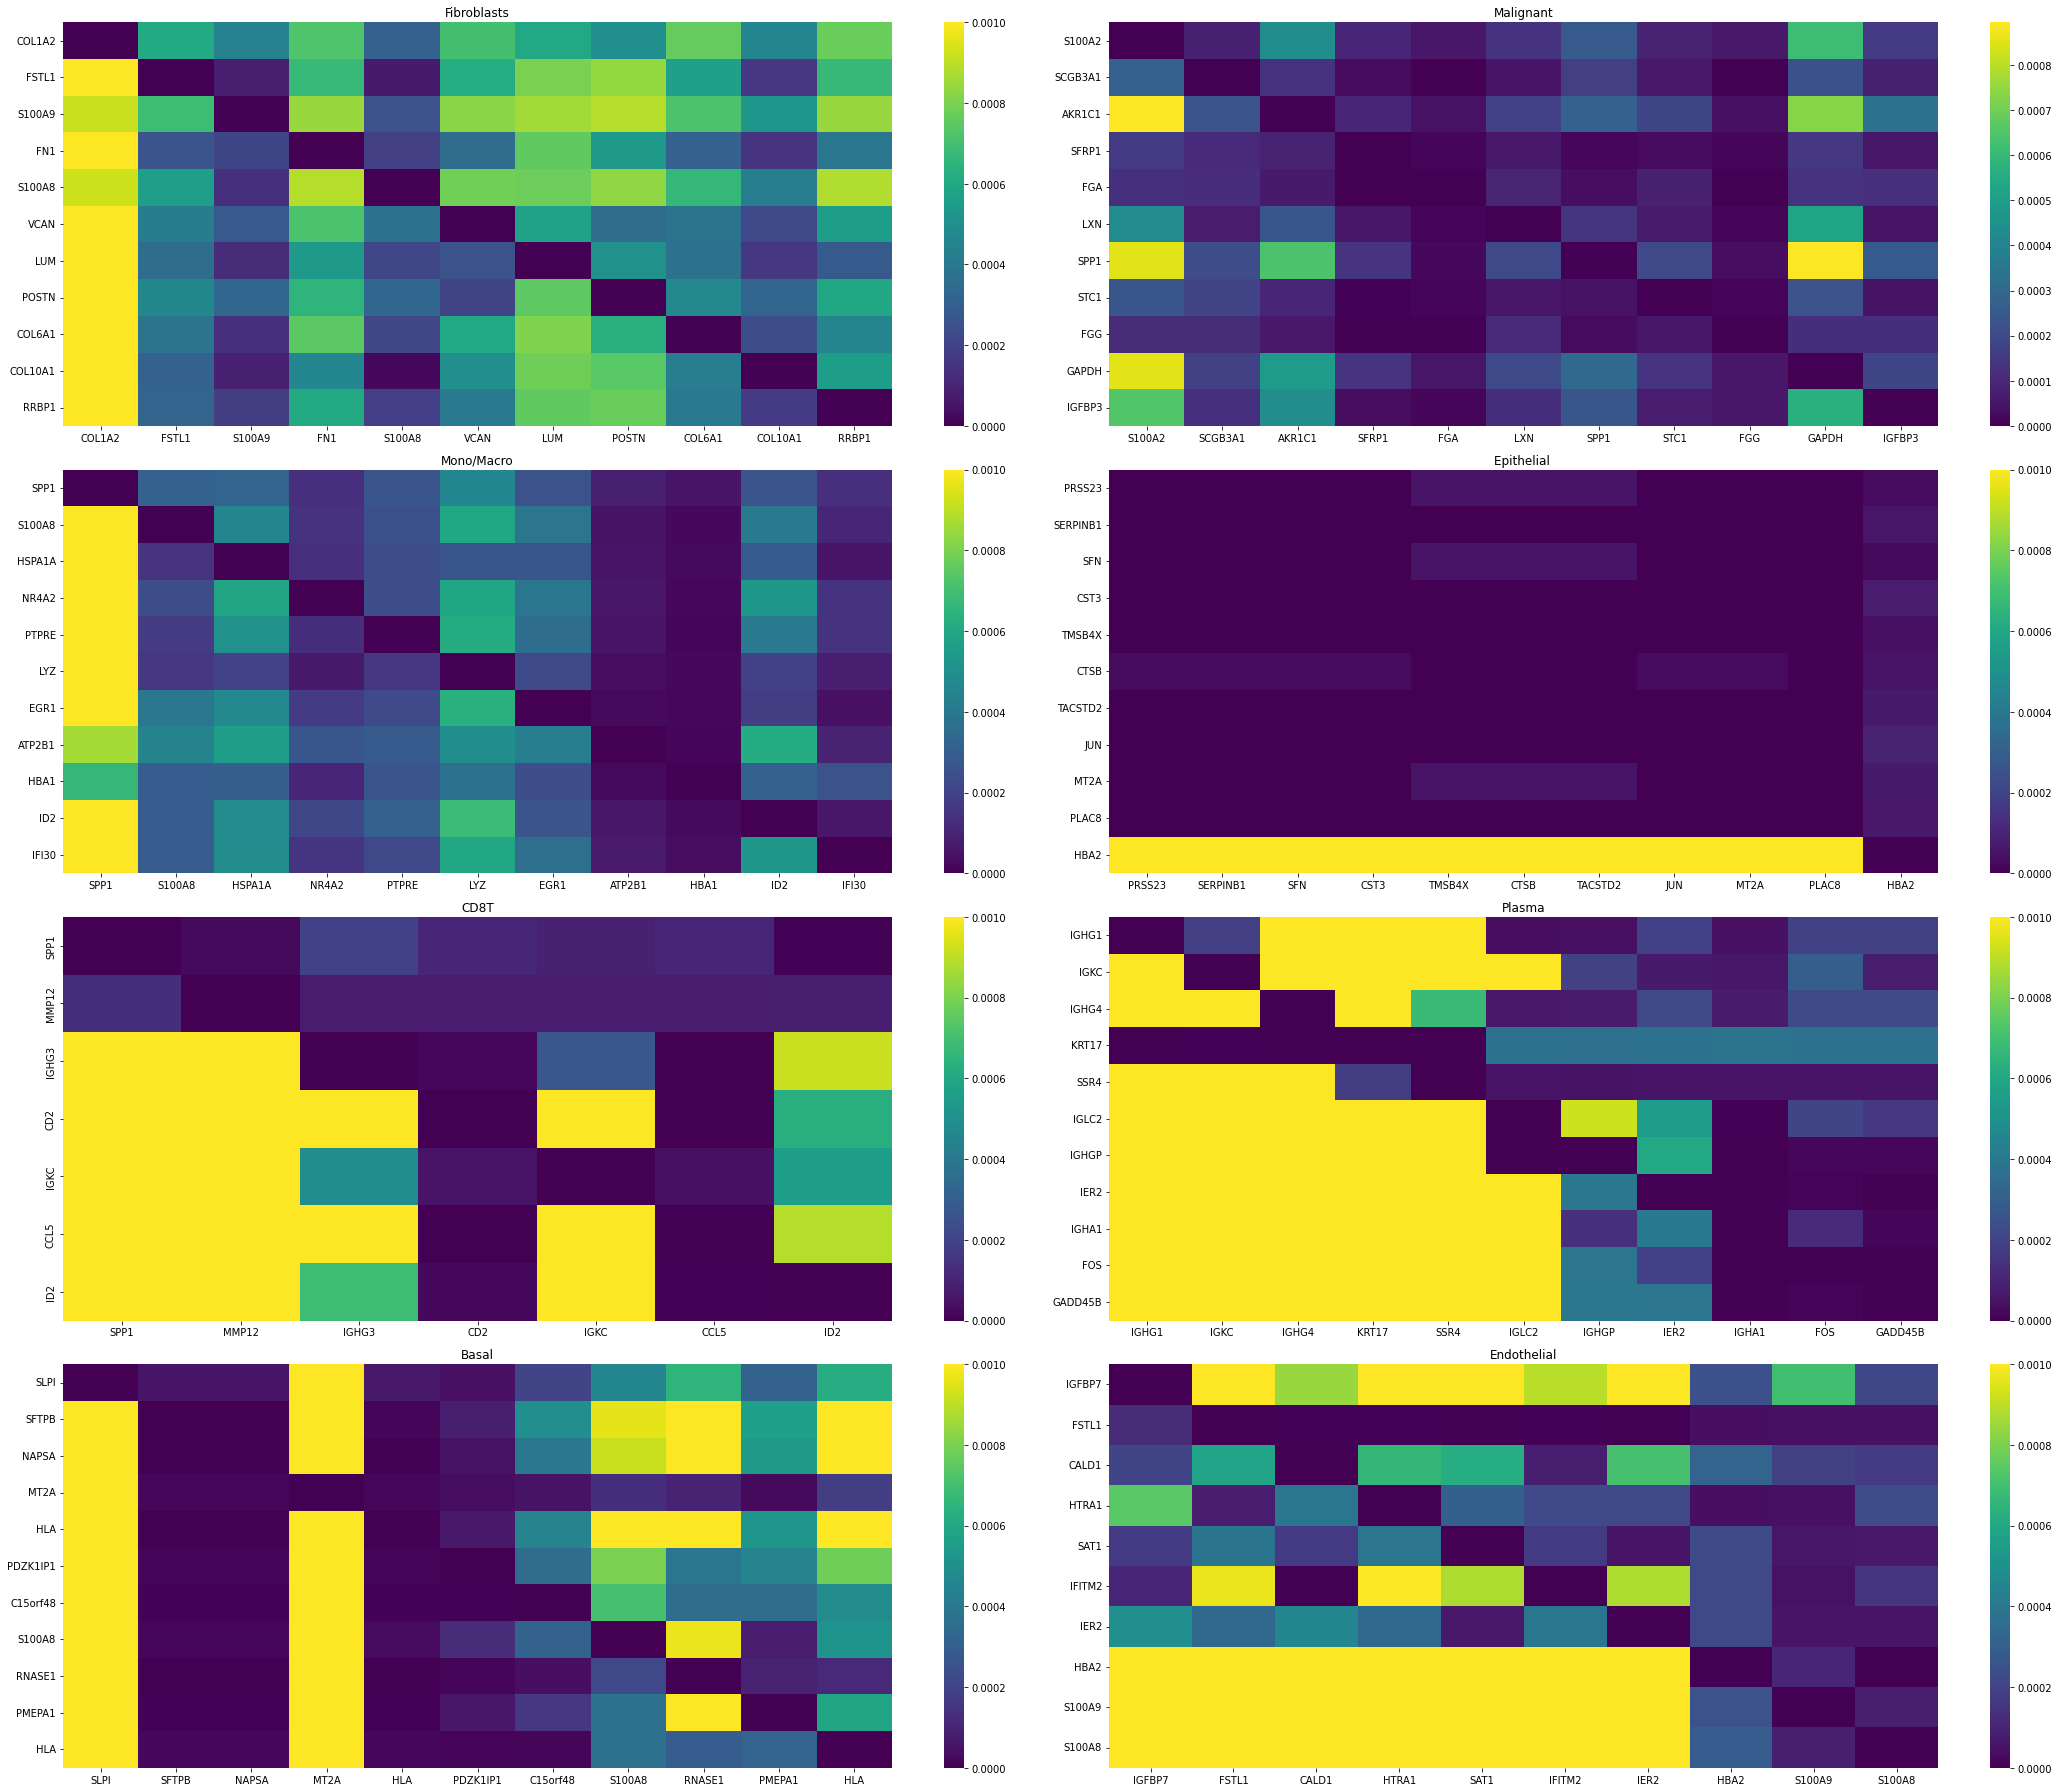

In [4]:
def get_top_genes_per_group(df,dfl,unique_celltypes,top_n):
    top_genes = {}
    for idx, ct in enumerate(unique_celltypes):
        ct_ylabel = dfl[dfl['celltype'] == ct].index.values
        df_attn = df.iloc[ct_ylabel,:].copy()
        
        df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
        df_attn = df_attn.groupby('gene').mean()

        df_attn = df_attn.unstack().reset_index()
        df_attn = df_attn.sort_values(0,ascending=False)
        df_attn = df_attn.iloc[:top_n,:]
        tp1 = df_attn['gene'].unique()[:top_n]
        tp0 = df_attn['level_0'].unique()[:top_n]
        top_genes[ct]=np.concatenate([tp0,tp1])        
    return top_genes
        


unique_celltypes = dfl['celltype'].unique()
top_n = 10
marker = get_top_genes_per_group(df,dfl,unique_celltypes,top_n)

# seq_marker = []
# for m in marker.keys(): 
#     for x in marker[m]: seq_marker.append(x)

fig, axes = plt.subplots(4, 2, figsize=(30, 25))

for idx, ct in enumerate(unique_celltypes):
    
    row, col = idx // 2, idx % 2
    
    ct_ylabel = dfl[dfl['celltype'] == ct].index.values
    df_attn = df.iloc[ct_ylabel,:].copy()
    df_attn[df_attn > .001] = .001

    sel_genes = [x for x in marker[ct] if x in df_attn.columns]
    df_attn = df_attn.loc[:,sel_genes]
    
    df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
    df_attn = df_attn[df_attn['gene'].isin(sel_genes)]
    df_attn = df_attn.groupby('gene').mean()

    df_attn = df_attn.loc[sel_genes,sel_genes]
    
    df_attn.columns = [x.split('-')[0] for x in df_attn.columns]
    df_attn.index = [x.split('-')[0] for x in df_attn.index]
    sns.heatmap(df_attn, ax=axes[row, col],
                yticklabels=df_attn.index,  
                xticklabels=df_attn.columns,  
                cmap='viridis' 
                )
    axes[row, col].set_title(ct)
    
plt.tight_layout()

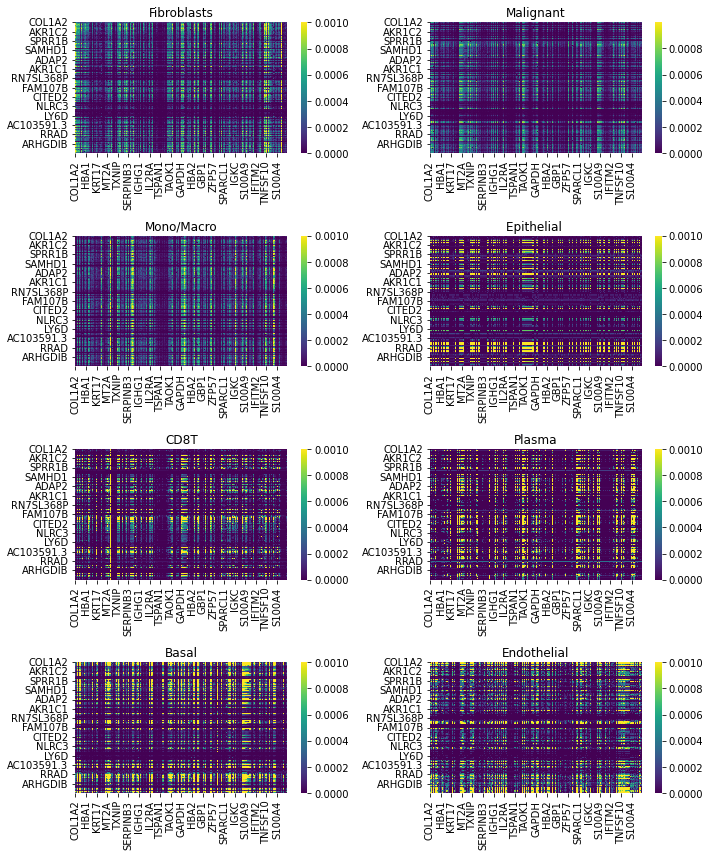

In [5]:

unique_celltypes = dfl['celltype'].unique()
top_n = 2000
marker = get_top_genes_per_group(df,dfl,unique_celltypes,top_n)

seq_marker = []
for m in marker.keys(): 
    for x in marker[m]: seq_marker.append(x)

fig, axes = plt.subplots(4, 2, figsize=(10, 12))

for idx, ct in enumerate(unique_celltypes):
    
    row, col = idx // 2, idx % 2
    
    ct_ylabel = dfl[dfl['celltype'] == ct].index.values
    df_attn = df.iloc[ct_ylabel,:].copy()
    df_attn[df_attn > .001] = .001

    sel_genes = [x for x in seq_marker if x in df_attn.columns]
    df_attn = df_attn.loc[:,sel_genes]
    
    df_attn['gene'] = [x.split('_')[1] for x in df_attn.index.values]
    df_attn = df_attn[df_attn['gene'].isin(seq_marker)]
    df_attn = df_attn.groupby('gene').mean()
    df_attn = df_attn.loc[seq_marker,seq_marker]
    
    df_attn.columns = [x.split('-')[0] for x in df_attn.columns]
    df_attn.index = [x.split('-')[0] for x in df_attn.index]
    sns.heatmap(df_attn, ax=axes[row, col],
                # yticklabels=df_attn.index,  
                # xticklabels=df_attn.columns,  
                cmap='viridis' 
                )
    axes[row, col].set_title(ct)
    
plt.tight_layout()